In [18]:
import numpy as np
import matplotlib.pyplot as plt
import re

In [19]:
import import_ipynb
import model

In [20]:
def parse_gcode_lines(lines):
    """
    Parse a subset of G-code:
    - G0 / G1 moves
    - X coordinate (mm)
    - F feedrate (mm/min)

    Returns list of (x_start_m, x_end_m, feed_m_per_s).
    """
    moves = []
    x_curr_mm = 0.0
    feed_default_mm_min = 600.0  # default feed if F not specified

    for raw in lines:
        line = raw.strip()
        if not line or line.startswith(";") or line.startswith("("):
            continue

        if line.startswith("G0") or line.startswith("G1"):
            parts = line.split()
            x_new_mm = x_curr_mm
            F_mm_min = feed_default_mm_min

            for p in parts:
                if p.startswith("X"):
                    # X10.0 -> 10.0
                    x_new_mm = float(p[1:])
                elif p.startswith("F"):
                    F_mm_min = float(p[1:])

            # convert to meters and m/s
            x0_m = x_curr_mm / 1000.0
            x1_m = x_new_mm / 1000.0
            v_feed = (F_mm_min / 1000.0) / 60.0  # mm/min -> m/s

            moves.append((x0_m, x1_m, v_feed))
            x_curr_mm = x_new_mm

    return moves


In [21]:
# Parser Example

gcode_example = [
    "G1 X10.0 F600",
    "G1 X25.0",
    "G0 X0.0 F1200",
]

parse_gcode_lines(gcode_example)


[(0.0, 0.01, 0.01), (0.01, 0.025, 0.01), (0.025, 0.0, 0.02)]

In [22]:
def generate_trapezoid_segment(x0, x1, v_cmd, Ts, a_max=0.5):
    """
    Generate a trapezoidal (or triangular) velocity profile between x0 and x1
    with commanded cruise speed v_cmd [m/s] and max acceleration a_max [m/s^2].
    Returns t_seg, x_seg.
    """
    dist = x1 - x0
    direction = np.sign(dist) if dist != 0 else 1.0
    L = abs(dist)

    if L == 0:
        return np.array([0.0]), np.array([x0])

    v_cmd = abs(v_cmd) * direction  # sign with direction
    v_abs = abs(v_cmd)

    # time to accelerate to v_cmd
    t_acc = v_abs / a_max
    d_acc = 0.5 * a_max * t_acc**2

    if 2 * d_acc >= L:
        # cannot reach v_cmd -> triangular profile
        v_peak = np.sqrt(L * a_max)
        t_acc = v_peak / a_max
        t_cruise = 0.0
    else:
        # true trapezoid
        d_cruise = L - 2 * d_acc
        t_cruise = d_cruise / v_abs

    t_total = 2 * t_acc + t_cruise
    N = int(np.round(t_total / Ts)) + 1
    t = Ts * np.arange(N)

    x = np.zeros(N)
    x[0] = x0

    for k in range(1, N):
        tk = t[k]

        if tk <= t_acc:
            # accel phase
            v = a_max * tk
        elif tk <= t_acc + t_cruise:
            # cruise
            v = v_abs
        else:
            # decel
            t_dec = tk - (t_acc + t_cruise)
            v = max(v_abs - a_max * t_dec, 0.0)

        v *= direction
        x[k] = x[k-1] + v * Ts

    # shift final point exactly to x1 to avoid drift
    x[-1] = x1

    return t, x


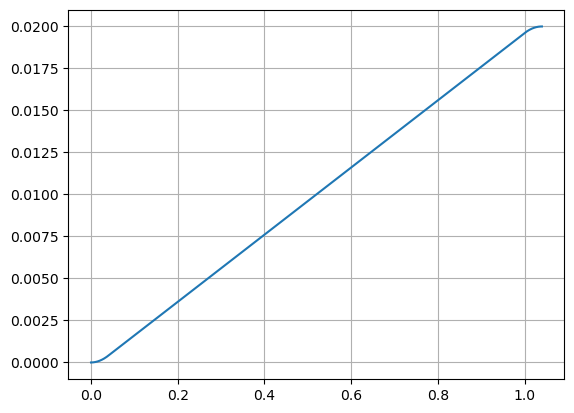

In [23]:
# Test

Ts = model.Ts  # from model
t_seg, x_seg = generate_trapezoid_segment(0.0, 0.02, 0.02, Ts)  # 2 cm move at 2 cm/s
plt.plot(t_seg, x_seg)
plt.grid(True)


In [24]:
def build_trajectory_from_gcode(lines, Ts, a_max=0.5):
    """
    Parse G-code lines and build a full reference trajectory x_ref[k].
    Returns t_all, x_ref_all.
    """
    moves = parse_gcode_lines(lines)

    t_all = []
    x_all = []

    t_offset = 0.0
    first = True

    for (x0, x1, v_feed) in moves:
        t_seg, x_seg = generate_trapezoid_segment(x0, x1, v_feed, Ts, a_max=a_max)

        if first:
            t_all.append(t_seg)
            x_all.append(x_seg)
            first = False
        else:
            # skip first sample to avoid duplicate timestamps at junction
            t_all.append(t_offset + t_seg[1:])
            x_all.append(x_seg[1:])

        t_offset = t_all[-1][-1]

    if not t_all:
        return np.array([]), np.array([])

    t_full = np.concatenate(t_all)
    x_full = np.concatenate(x_all)

    return t_full, x_full


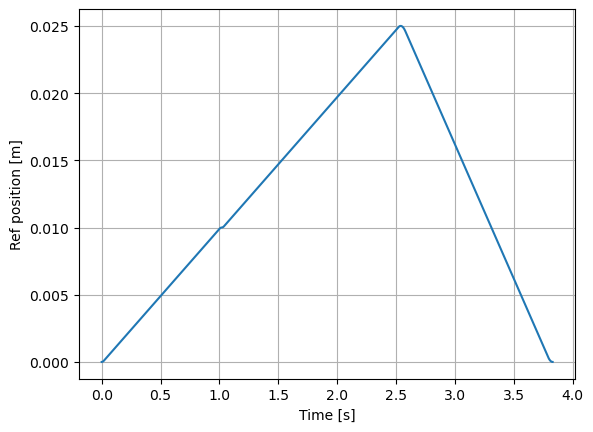

In [26]:
# Test

t_traj, x_traj = build_trajectory_from_gcode(gcode_example, Ts=model.Ts)
plt.figure()
plt.plot(t_traj, x_traj)
plt.xlabel("Time [s]")
plt.ylabel("Ref position [m]")
plt.grid(True)


In [29]:
def simulate_closed_loop_trajectory(x_ref_traj, Ts, u_max=0.25):
    """
    Follow a time-varying reference trajectory x_ref_traj[k]
    using the LQR controller from model.py.
    Uses the same noise/disturbance toggles as the model's single-step sim.
    """

    Ad = model.Ad
    Bd = model.Bd
    K  = model.K_lqr
    N_r = model.N_r

    N_steps = len(x_ref_traj)
    n = Ad.shape[0]

    x = np.zeros((n, 1))

    xs = np.zeros((N_steps, n))
    ys = np.zeros(N_steps)
    us = np.zeros(N_steps)

    Cpos = np.array([[0., 0., 1., 0.]])

    for k in range(N_steps):
        x_ref = x_ref_traj[k]

        # true output
        y_true = float(Cpos @ x)
        y_meas = y_true

        # you can later pull model. USE_SENSOR_NOISE etc. if wanted
        u = float(-K @ x + N_r * x_ref)
        u = np.clip(u, -u_max, u_max)

        x = Ad @ x + Bd * u

        xs[k, :] = x.ravel()
        ys[k]    = y_true
        us[k]    = u

    t = Ts * np.arange(N_steps)
    return t, xs, ys, us


/var/folders/fy/27_xvl657tbbmw22t433h_jc0000gn/T/ipykernel_7440/3293258180.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_true = float(Cpos @ x)
/var/folders/fy/27_xvl657tbbmw22t433h_jc0000gn/T/ipykernel_7440/3293258180.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = float(-K @ x + N_r * x_ref)


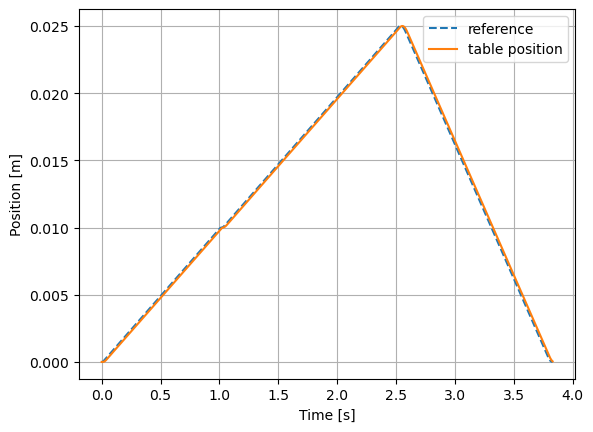

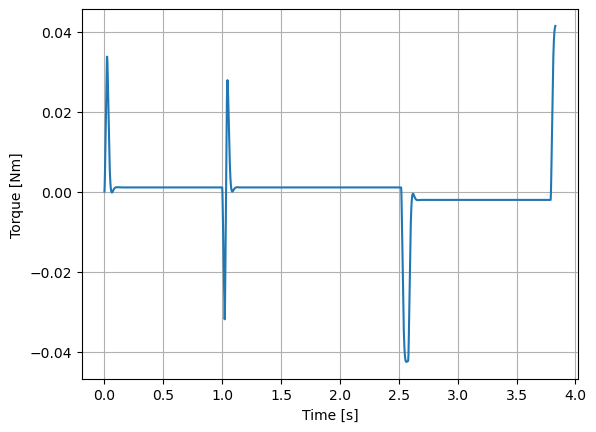

In [30]:
# fake G-code program
gcode_example = [
    "G1 X10.0 F600",
    "G1 X25.0 F600",
    "G0 X0.0 F1200",
]

# build trajectory
Ts = model.Ts
t_traj, x_traj = build_trajectory_from_gcode(gcode_example, Ts)

# simulate closed-loop tracking
t, xs, ys, us = simulate_closed_loop_trajectory(x_traj, Ts, u_max=0.25)

plt.figure()
plt.plot(t_traj, x_traj, '--', label='reference')
plt.plot(t, ys, label='table position')
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t, us)
plt.xlabel("Time [s]")
plt.ylabel("Torque [Nm]")
plt.grid(True)
